In [1]:
import pandas as pd
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import warnings
# turn off performance warning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

**Prepare Data**

In [2]:
def load_data(data_path: str, usecols: [] = None):
    if usecols is not None: 
        df = pd.read_parquet(data_path, columns=usecols)
    else: 
        df = pd.read_parquet(data_path)
    
    return df

In [3]:
train_data = load_data(data_path="/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet")

In [4]:
train_labels = pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv')
train_data = pd.merge(train_data, train_labels, on = 'customer_ID', how = 'left')

**Preprocessing 1**

**1/ Handle MISSING VALUES**

In [5]:
missing_values = train_data.isnull().sum()
missing_df = missing_values.to_frame().reset_index().rename(columns={"index": "Feature", 0: "Number of missing values"}).sort_values(["Number of missing values"], ascending=False).reset_index(drop=True)
missing_df['% missing'] = np.round((missing_df["Number of missing values"] /len(train_data) )*100, 2)
missing_70 = missing_df.loc[missing_df['% missing'] > 70, 'Feature'].values
del missing_values
del missing_df
print(missing_70)

['D_88' 'D_110' 'B_39' 'D_73' 'B_42' 'D_134' 'B_29' 'D_132' 'D_76' 'D_42'
 'D_142' 'D_53']


In [6]:
# list of features
features = train_data.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
# categorical features:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
cat_cols = [col for col in cat_cols if col not in missing_70] # make sure dropped columns are not listed in the list
    
# numerical features:
num_features = [col for col in features if col not in cat_cols and col not in missing_70 and col != "target"]

In [7]:
def preprocessing(df: pd.DataFrame):
    # drop columns with >70% values missed
    processed_data = df.drop(missing_70, axis = 1)
   
    # handle missing values: 
    # impute missing values for numerical features
    processed_data[num_features] = df[num_features].fillna(df[num_features].mean())
    # impute missing values for categorical features
    for col in cat_cols:
        processed_data[col] = df[col].fillna(df[col].mode()[0])
    # drop rows with missing values if any
    processed_data.dropna(inplace = True)
    print('preprocessing done')
    
    return processed_data
        

In [8]:
pro_train = preprocessing(train_data)
del train_data

preprocessing done


**2/ One-Hot Encoding for categorical features**

In [9]:
unique_categories = {}
for col in cat_cols:
    unique_categories[col] = set(pro_train[col].unique()) 

# Combine unique categories and create a mapping to integers
category_to_int = {col: {category: i for i, category in enumerate(categories)} for col, categories in unique_categories.items()}
category_to_int

{'B_30': {0: 0, 1: 1, 2: 2, -1: 3},
 'B_38': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, -1: 7},
 'D_114': {0: 0, 1: 1, -1: 2},
 'D_116': {0: 0, 1: 1, -1: 2},
 'D_117': {0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, -1: 7},
 'D_120': {0: 0, 1: 1, -1: 2},
 'D_126': {0: 0, 1: 1, 2: 2, -1: 3},
 'D_63': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5},
 'D_64': {0: 0, 1: 1, 2: 2, 3: 3, -1: 4},
 'D_66': {0: 0, 1: 1, -1: 2},
 'D_68': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, -1: 7}}

In [10]:
def one_hot_encoding(df, categorical_features, category_to_int):
    df[categorical_features] = df[categorical_features].apply(lambda col: col.map(category_to_int[col.name]))
    df = pd.get_dummies(df, columns=categorical_features)
    
    return df

In [11]:
pro_train = one_hot_encoding(pro_train, cat_cols, category_to_int)
new_cat_cols = [x for x in pro_train.columns if x not in num_features and x != "S_2" and x != "customer_ID" and x != "target"]

In [12]:
pro_train[new_cat_cols].head()

,B_30_0,B_30_1,B_30_2,B_30_3,B_38_0,B_38_1,B_38_2,B_38_3,B_38_4,B_38_5,...,D_66_1,D_66_2,D_68_0,D_68_1,D_68_2,D_68_3,D_68_4,D_68_5,D_68_6,D_68_7
0,True,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
1,True,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,True,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,True,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,True,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False


**DATA AGGREGATION (transaction level to customer level)**

In [13]:
def aggregation(df: pd.DataFrame, labels: pd.DataFrame = None):
    
    print("start aggregating numerical features ..")
    # numerical features aggregated by time period
    df_num_agg = df.groupby('customer_ID')[num_features].agg(['mean', 'std', 'min', 'max', 'first', 'last'])
    df_num_agg.columns = ['_'.join(x) for x in df_num_agg.columns]
    df_num_agg.reset_index()
    
    print('start creating lag features ..')
    # Lag Features: First / Last statemeants
    for col in df_num_agg.columns:
        if 'last' in col and col.replace('last', 'first') in df_num_agg.columns:
            df_num_agg[col + '_lag_sub'] = df_num_agg[col] - df_num_agg[col.replace('last', 'first')]
            # df_num_agg[col + '_lag_div'] = df_num_agg[col] / df_num_agg[col.replace('last', 'first')]
            
    print('start aggregating categorical features ..')
    # categorical feartures aggregated by time period
    df_cat_agg = df.groupby('customer_ID')[new_cat_cols].agg(['count', 'first', 'last', 'nunique'])
    df_cat_agg.columns = ['_'.join(x) for x in df_cat_agg.columns]
    df_cat_agg.reset_index()
    
    # merge sub-dataframe
    if labels is not None:
        df_agg = df_num_agg.merge(df_cat_agg, how = 'inner', on = 'customer_ID').merge(labels, how = 'inner', on = 'customer_ID')
    else:
        df_agg = df_num_agg.merge(df_cat_agg, how = 'inner', on = 'customer_ID')
    # drop customer_ID after merging
    df_agg.drop('customer_ID', axis = 1, inplace = True)
    
    del df_num_agg, df_cat_agg
    
    print('feature engineering completed')
    print('Dimensions after egineering: ', df_agg.shape )
    
    return df_agg
    

In [14]:
agg_train = aggregation(pro_train.drop(columns=['target']), train_labels)
del pro_train

start aggregating numerical features ..
start creating lag features ..
start aggregating categorical features ..
feature engineering completed
Dimensions after egineering:  (458913, 1376)


In [15]:
agg_train.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_first,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_68_5_nunique,D_68_6_count,D_68_6_first,D_68_6_last,D_68_6_nunique,D_68_7_count,D_68_7_first,D_68_7_last,D_68_7_nunique,target
0,0.933824,0.024194,0.868580,0.960384,0.938469,0.934745,0.230769,0.832050,0,3,...,1,13,True,True,1,13,False,False,1,0
1,0.899820,0.022119,0.861109,0.929122,0.929122,0.880519,7.153846,6.743468,0,19,...,1,13,True,True,1,13,False,False,1,0
2,0.878454,0.028911,0.797670,0.904482,0.876615,0.880875,0.000000,0.000000,0,0,...,1,13,True,True,1,13,False,False,1,0
3,0.598969,0.020107,0.567442,0.623392,0.567442,0.621776,1.538462,3.017046,0,9,...,1,13,False,False,2,13,False,False,1,0
4,0.891679,0.042325,0.805045,0.940382,0.936842,0.871900,0.000000,0.000000,0,0,...,1,13,True,True,1,13,False,False,1,0


**Handle MISSING VALUES 2**

In [16]:
missing_values = agg_train.isnull().sum()
missing_df = missing_values.to_frame().reset_index().rename(columns={"index": "Feature", 0: "Number of missing values"}).sort_values(["Number of missing values"], ascending=False).reset_index(drop=True)
missing_df['% missing'] = np.round((missing_df["Number of missing values"] /len(agg_train) )*100, 2)
missing_df = missing_df[missing_df['% missing'] != 0]
missing_df

,Feature,Number of missing values,% missing
0,D_135_std,5120,1.12
1,D_56_std,5120,1.12
2,S_8_std,5120,1.12
3,R_22_std,5120,1.12
4,B_8_std,5120,1.12
...,...,...,...
160,D_96_std,5120,1.12
161,D_105_std,5120,1.12
162,B_26_std,5120,1.12
163,B_4_std,5120,1.12


Obseravtion: the % of missing values for _std columns is only 1.12%, then i decide to drop all the rows with missing values

In [17]:
agg_train.dropna(subset=['D_135_std'], inplace=True)
agg_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 453793 entries, 0 to 458912
Columns: 1376 entries, P_2_mean to target
dtypes: bool(110), float32(567), float64(168), int16(45), int64(111), int8(375)
memory usage: 2.1 GB


In [18]:
del missing_values
del missing_df

**Convert boolean values to numerical data**

In [19]:
features= agg_train.drop(['target'], axis = 1).columns.to_list()
cat_cols = [col for col in features if agg_train[col].dtype == 'O' or agg_train[col].dtype == 'bool']

In [20]:
# Define the conversion function
def convert_to_numeric(value):
    mapping = {"[True]": 1, "[False]": 0}
    if isinstance(value, bool):
        return int(value)
    elif isinstance(value, str):
        return mapping.get(value, value)
    else:
        return value

# Apply the conversion function to columns with object and boolean dtype
for col in cat_cols:
    agg_train[col] = agg_train[col].apply(lambda x: convert_to_numeric(x))
print("done!")


done!


**Feature Selection**

**1/ Correlation Matrix**

In [21]:
# correlation_matrix = agg_train[features].corr()

In [22]:
'''
# Auto drop columns with high correlation coeffition (>80%)
columns = np.full((correlation_matrix.shape[0],), True, dtype=bool)
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[0]):
        if correlation_matrix.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = agg_train.drop(columns=['target']).columns[columns]
'''

"\n# Auto drop columns with high correlation coeffition (>80%)\ncolumns = np.full((correlation_matrix.shape[0],), True, dtype=bool)\nfor i in range(correlation_matrix.shape[0]):\n    for j in range(i+1, correlation_matrix.shape[0]):\n        if correlation_matrix.iloc[i,j] >= 0.8:\n            if columns[j]:\n                columns[j] = False\nselected_columns = agg_train.drop(columns=['target']).columns[columns]\n"

In [23]:
# selected_columns = selected_columns.to_numpy()

In [24]:
'''
print("selected features after correlation filtering at 80%: ", len(selected_columns))
# Convert array to a list of strings with commas and single quotes
array_str = ', '.join(f"'{elem}'" for elem in selected_columns)
print(f"[{array_str}]")
'''

'\nprint("selected features after correlation filtering at 80%: ", len(selected_columns))\n# Convert array to a list of strings with commas and single quotes\narray_str = \', \'.join(f"\'{elem}\'" for elem in selected_columns)\nprint(f"[{array_str}]")\n'

In [25]:
selected_columns = ['P_2_mean', 'P_2_std', 'D_39_mean', 'D_39_min', 'D_39_first', 'D_39_last', 'B_1_mean', 'B_1_std', 'B_2_mean', 'B_2_std', 'B_2_max', 'B_2_first', 'R_1_mean', 'R_1_min', 'R_1_first', 'R_1_last', 'S_3_mean', 'S_3_std', 'S_3_first', 'D_41_mean', 'D_41_std', 'D_41_min', 'D_41_first', 'B_3_mean', 'B_3_std', 'D_43_mean', 'D_43_std', 'D_43_first', 'D_43_last', 'D_44_mean', 'D_44_std', 'B_4_mean', 'B_4_std', 'D_45_mean', 'D_45_std', 'B_5_mean', 'B_5_min', 'B_5_first', 'B_5_last', 'R_2_mean', 'R_2_std', 'R_2_min', 'R_2_first', 'R_2_last', 'D_46_mean', 'D_46_std', 'D_46_min', 'D_46_first', 'D_46_last', 'D_47_mean', 'D_47_std', 'D_48_mean', 'D_48_std', 'D_49_mean', 'D_49_std', 'D_49_min', 'B_6_mean', 'B_6_min', 'B_6_first', 'B_6_last', 'B_7_mean', 'B_7_std', 'B_8_mean', 'B_8_std', 'D_50_mean', 'D_50_std', 'D_50_min', 'D_50_first', 'D_50_last', 'D_51_mean', 'D_51_std', 'B_9_mean', 'B_9_std', 'R_3_mean', 'R_3_std', 'R_3_min', 'R_3_first', 'R_3_last', 'D_52_mean', 'D_52_std', 'P_3_mean', 'P_3_std', 'P_3_min', 'P_3_max', 'P_3_first', 'P_3_last', 'B_10_mean', 'B_10_min', 'B_10_first', 'B_10_last', 'S_5_mean', 'S_5_min', 'S_5_first', 'S_5_last', 'S_6_mean', 'S_6_std', 'S_6_max', 'S_6_first', 'D_54_mean', 'D_54_std', 'D_54_min', 'D_54_max', 'D_54_first', 'R_4_min', 'R_4_first', 'R_4_last', 'B_12_mean', 'B_12_std', 'S_8_mean', 'S_8_std', 'D_55_std', 'D_56_mean', 'D_56_std', 'R_5_min', 'R_5_first', 'R_5_last', 'D_58_mean', 'D_58_std', 'S_9_mean', 'S_9_min', 'S_9_first', 'S_9_last', 'B_14_mean', 'D_59_mean', 'D_59_std', 'D_59_min', 'D_60_mean', 'D_60_std', 'D_61_std', 'S_11_mean', 'S_11_std', 'S_11_min', 'S_11_max', 'S_11_first', 'S_11_last', 'D_62_mean', 'D_62_std', 'D_65_mean', 'D_65_min', 'D_65_first', 'D_65_last', 'B_16_mean', 'B_16_std', 'B_17_mean', 'B_17_std', 'B_17_min', 'B_17_max', 'B_17_first', 'B_17_last', 'B_18_std', 'B_19_std', 'B_20_std', 'S_12_mean', 'S_12_min', 'S_12_first', 'S_12_last', 'R_6_mean', 'R_6_min', 'R_6_first', 'R_6_last', 'S_13_mean', 'S_13_std', 'B_21_mean', 'B_21_min', 'B_21_first', 'B_21_last', 'D_69_mean', 'D_69_min', 'D_69_last', 'B_22_std', 'B_22_min', 'B_22_first', 'D_70_mean', 'D_70_std', 'D_70_min', 'D_70_first', 'D_70_last', 'D_71_mean', 'D_71_std', 'D_71_min', 'D_72_mean', 'D_72_std', 'D_72_min', 'D_72_first', 'S_15_mean', 'S_15_std', 'S_15_min', 'S_15_max', 'S_15_first', 'S_15_last', 'P_4_mean', 'P_4_std', 'B_24_mean', 'B_24_min', 'B_24_first', 'R_7_mean', 'R_7_min', 'R_7_first', 'R_7_last', 'D_77_std', 'B_25_mean', 'B_25_std', 'B_26_mean', 'B_26_min', 'B_26_first', 'B_26_last', 'D_78_mean', 'D_78_std', 'D_78_min', 'D_78_first', 'D_79_mean', 'D_79_std', 'D_79_min', 'R_8_min', 'R_8_first', 'R_9_mean', 'R_9_std', 'S_16_mean', 'S_16_min', 'S_16_first', 'S_16_last', 'D_80_mean', 'D_80_std', 'D_80_min', 'R_10_min', 'R_10_first', 'R_10_last', 'R_11_mean', 'R_11_min', 'R_11_first', 'R_11_last', 'B_27_mean', 'B_27_std', 'B_27_min', 'B_27_first', 'B_27_last', 'D_81_mean', 'D_81_std', 'D_81_min', 'D_81_first', 'D_82_mean', 'D_82_std', 'S_17_mean', 'S_17_min', 'S_17_first', 'S_17_last', 'R_12_mean', 'R_12_std', 'R_12_max', 'R_12_first', 'B_28_mean', 'R_13_min', 'R_13_first', 'R_13_last', 'D_83_mean', 'D_83_std', 'D_83_min', 'R_14_mean', 'R_14_min', 'R_14_first', 'R_14_last', 'R_15_mean', 'R_15_min', 'R_15_first', 'R_15_last', 'D_84_min', 'D_84_first', 'R_16_mean', 'R_16_min', 'R_16_first', 'R_16_last', 'S_18_mean', 'S_18_std', 'S_18_min', 'S_18_last', 'D_86_mean', 'D_86_std', 'D_87_mean', 'D_87_std', 'D_87_min', 'D_87_first', 'R_17_min', 'R_17_first', 'R_17_last', 'R_18_mean', 'R_18_min', 'R_18_first', 'R_18_last', 'B_31_mean', 'B_31_std', 'B_31_max', 'B_31_first', 'B_31_last', 'S_19_mean', 'S_19_std', 'S_19_min', 'S_19_first', 'S_19_last', 'R_19_mean', 'R_19_std', 'B_32_mean', 'B_32_std', 'B_32_min', 'B_32_first', 'B_32_last', 'S_20_mean', 'S_20_std', 'S_20_min', 'S_20_first', 'S_20_last', 'R_20_min', 'R_20_first', 'R_20_last', 'R_21_std', 'R_21_min', 'R_21_first', 'R_21_last', 'D_89_mean', 'D_89_last', 'R_22_mean', 'R_22_min', 'R_22_first', 'R_22_last', 'R_23_mean', 'R_23_min', 'R_23_first', 'R_23_last', 'D_91_mean', 'D_91_std', 'D_91_min', 'D_92_mean', 'D_92_std', 'D_92_min', 'D_93_mean', 'D_93_std', 'D_93_min', 'D_94_mean', 'D_94_std', 'D_94_min', 'R_24_mean', 'R_24_min', 'R_24_first', 'R_24_last', 'R_25_mean', 'R_25_min', 'R_25_first', 'R_25_last', 'D_96_mean', 'D_96_std', 'D_96_min', 'D_96_first', 'D_96_last', 'S_22_mean', 'S_22_std', 'S_22_min', 'S_22_max', 'S_22_first', 'S_22_last', 'S_23_mean', 'S_23_std', 'S_23_min', 'S_23_first', 'S_23_last', 'S_25_mean', 'S_25_std', 'S_25_max', 'S_25_first', 'S_25_last', 'S_26_mean', 'D_102_mean', 'D_102_std', 'D_103_mean', 'D_103_std', 'D_103_min', 'D_105_mean', 'D_105_std', 'D_106_mean', 'D_106_min', 'D_106_first', 'B_36_mean', 'B_36_std', 'B_36_min', 'R_26_mean', 'R_26_std', 'R_27_mean', 'R_27_std', 'D_108_mean', 'D_108_min', 'D_108_first', 'D_108_last', 'D_109_mean', 'D_109_std', 'D_109_min', 'D_112_mean', 'D_112_std', 'D_112_max', 'D_112_first', 'D_112_last', 'B_40_mean', 'B_40_min', 'B_40_first', 'B_40_last', 'S_27_mean', 'S_27_std', 'S_27_min', 'S_27_first', 'S_27_last', 'D_113_mean', 'D_113_std', 'D_115_mean', 'D_115_std', 'D_118_std', 'D_121_mean', 'D_121_std', 'D_122_mean', 'D_122_std', 'D_123_mean', 'D_123_std', 'D_123_max', 'D_123_last', 'D_124_mean', 'D_124_std', 'D_125_mean', 'D_125_std', 'D_125_max', 'D_125_first', 'D_125_last', 'D_127_mean', 'D_127_std', 'D_127_min', 'D_128_mean', 'D_128_std', 'D_129_mean', 'D_129_std', 'D_129_min', 'B_41_mean', 'B_41_min', 'B_41_first', 'D_130_mean', 'D_130_std', 'D_131_std', 'D_133_mean', 'D_133_std', 'D_133_min', 'D_133_first', 'R_28_mean', 'R_28_std', 'R_28_min', 'R_28_first', 'R_28_last', 'D_135_mean', 'D_135_min', 'D_135_first', 'D_135_last', 'D_139_mean', 'D_139_std', 'D_139_min', 'D_140_mean', 'D_140_std', 'D_140_min', 'D_140_last', 'D_144_mean', 'D_144_std', 'D_145_mean', 'D_145_std', 'B_1_last_lag_sub', 'B_2_last_lag_sub', 'R_1_last_lag_sub', 'S_3_last_lag_sub', 'B_3_last_lag_sub', 'D_43_last_lag_sub', 'D_44_last_lag_sub', 'B_4_last_lag_sub', 'D_45_last_lag_sub', 'B_5_last_lag_sub', 'D_46_last_lag_sub', 'D_47_last_lag_sub', 'D_48_last_lag_sub', 'D_49_last_lag_sub', 'B_6_last_lag_sub', 'B_7_last_lag_sub', 'B_8_last_lag_sub', 'D_50_last_lag_sub', 'D_51_last_lag_sub', 'B_9_last_lag_sub', 'R_3_last_lag_sub', 'D_52_last_lag_sub', 'B_10_last_lag_sub', 'S_5_last_lag_sub', 'S_6_last_lag_sub', 'B_12_last_lag_sub', 'S_8_last_lag_sub', 'D_55_last_lag_sub', 'D_56_last_lag_sub', 'B_13_last_lag_sub', 'D_58_last_lag_sub', 'S_9_last_lag_sub', 'B_14_last_lag_sub', 'D_60_last_lag_sub', 'D_61_last_lag_sub', 'S_11_last_lag_sub', 'D_62_last_lag_sub', 'B_16_last_lag_sub', 'B_17_last_lag_sub', 'B_18_last_lag_sub', 'B_19_last_lag_sub', 'B_20_last_lag_sub', 'S_12_last_lag_sub', 'S_13_last_lag_sub', 'B_21_last_lag_sub', 'D_69_last_lag_sub', 'B_22_last_lag_sub', 'D_70_last_lag_sub', 'D_71_last_lag_sub', 'D_72_last_lag_sub', 'S_15_last_lag_sub', 'P_4_last_lag_sub', 'R_7_last_lag_sub', 'D_77_last_lag_sub', 'B_25_last_lag_sub', 'B_26_last_lag_sub', 'D_78_last_lag_sub', 'D_79_last_lag_sub', 'R_9_last_lag_sub', 'S_16_last_lag_sub', 'D_80_last_lag_sub', 'R_11_last_lag_sub', 'B_27_last_lag_sub', 'D_81_last_lag_sub', 'D_82_last_lag_sub', 'S_17_last_lag_sub', 'R_12_last_lag_sub', 'B_28_last_lag_sub', 'D_83_last_lag_sub', 'R_14_last_lag_sub', 'R_16_last_lag_sub', 'S_18_last_lag_sub', 'D_86_last_lag_sub', 'S_19_last_lag_sub', 'R_19_last_lag_sub', 'B_32_last_lag_sub', 'S_20_last_lag_sub', 'R_21_last_lag_sub', 'D_89_last_lag_sub', 'R_22_last_lag_sub', 'R_23_last_lag_sub', 'D_91_last_lag_sub', 'D_92_last_lag_sub', 'D_93_last_lag_sub', 'D_94_last_lag_sub', 'D_96_last_lag_sub', 'S_22_last_lag_sub', 'S_23_last_lag_sub', 'S_25_last_lag_sub', 'S_26_last_lag_sub', 'D_102_last_lag_sub', 'D_103_last_lag_sub', 'D_104_last_lag_sub', 'D_105_last_lag_sub', 'R_26_last_lag_sub', 'R_27_last_lag_sub', 'D_108_last_lag_sub', 'D_109_last_lag_sub', 'D_112_last_lag_sub', 'B_40_last_lag_sub', 'S_27_last_lag_sub', 'D_113_last_lag_sub', 'D_115_last_lag_sub', 'D_118_last_lag_sub', 'D_121_last_lag_sub', 'D_122_last_lag_sub', 'D_123_last_lag_sub', 'D_125_last_lag_sub', 'D_127_last_lag_sub', 'D_128_last_lag_sub', 'D_129_last_lag_sub', 'B_41_last_lag_sub', 'D_130_last_lag_sub', 'D_131_last_lag_sub', 'D_133_last_lag_sub', 'R_28_last_lag_sub', 'D_135_last_lag_sub', 'D_139_last_lag_sub', 'D_140_last_lag_sub', 'D_141_last_lag_sub', 'D_144_last_lag_sub', 'D_145_last_lag_sub', 'B_30_0_count', 'B_30_0_first', 'B_30_0_last', 'B_30_1_last', 'B_30_2_first', 'B_30_2_last', 'B_30_2_nunique', 'B_30_3_first', 'B_30_3_last', 'B_38_0_first', 'B_38_0_last', 'B_38_0_nunique', 'B_38_1_first', 'B_38_1_last', 'B_38_1_nunique', 'B_38_2_first', 'B_38_2_last', 'B_38_2_nunique', 'B_38_3_first', 'B_38_3_last', 'B_38_3_nunique', 'B_38_4_first', 'B_38_4_last', 'B_38_4_nunique', 'B_38_5_first', 'B_38_5_last', 'B_38_5_nunique', 'B_38_6_first', 'B_38_6_last', 'B_38_6_nunique', 'B_38_7_last', 'D_114_0_first', 'D_114_0_last', 'D_114_0_nunique', 'D_114_1_first', 'D_114_1_last', 'D_114_1_nunique', 'D_114_2_last', 'D_116_0_last', 'D_116_1_first', 'D_116_1_last', 'D_117_0_first', 'D_117_0_last', 'D_117_0_nunique', 'D_117_1_first', 'D_117_1_last', 'D_117_1_nunique', 'D_117_2_first', 'D_117_2_last', 'D_117_2_nunique', 'D_117_3_first', 'D_117_3_last', 'D_117_3_nunique', 'D_117_4_first', 'D_117_4_last', 'D_117_4_nunique', 'D_117_5_first', 'D_117_5_last', 'D_117_5_nunique', 'D_117_6_first', 'D_117_6_last', 'D_117_6_nunique', 'D_120_0_first', 'D_120_0_last', 'D_120_0_nunique', 'D_120_1_first', 'D_120_1_last', 'D_120_1_nunique', 'D_126_0_first', 'D_126_0_last', 'D_126_0_nunique', 'D_126_1_first', 'D_126_1_last', 'D_126_1_nunique', 'D_126_2_first', 'D_126_2_last', 'D_126_2_nunique', 'D_126_3_last', 'D_63_0_nunique', 'D_63_1_first', 'D_63_1_last', 'D_63_1_nunique', 'D_63_2_first', 'D_63_2_last', 'D_63_2_nunique', 'D_63_3_first', 'D_63_3_nunique', 'D_63_4_first', 'D_63_4_last', 'D_63_4_nunique', 'D_63_5_first', 'D_63_5_last', 'D_63_5_nunique', 'D_64_0_first', 'D_64_0_last', 'D_64_0_nunique', 'D_64_1_first', 'D_64_1_last', 'D_64_1_nunique', 'D_64_2_first', 'D_64_2_last', 'D_64_2_nunique', 'D_64_3_first', 'D_64_3_last', 'D_64_3_nunique', 'D_64_4_last', 'D_66_0_first', 'D_66_0_last', 'D_66_0_nunique', 'D_66_1_first', 'D_66_1_nunique', 'D_66_2_first', 'D_66_2_nunique', 'D_68_0_first', 'D_68_0_last', 'D_68_1_first', 'D_68_1_last', 'D_68_1_nunique', 'D_68_2_first', 'D_68_2_last', 'D_68_2_nunique', 'D_68_3_first', 'D_68_3_last', 'D_68_3_nunique', 'D_68_4_first', 'D_68_4_last', 'D_68_4_nunique', 'D_68_5_first', 'D_68_5_last', 'D_68_5_nunique', 'D_68_6_first', 'D_68_6_last', 'D_68_6_nunique']
print("number of selected features: ",len(selected_columns))

number of selected features:  720


In [26]:
x= agg_train[selected_columns]
y= agg_train['target']
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


**2.1/ Recursive Feature Elimination using Cross Validation (RFEcv)**

In [27]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

lgbm = LGBMClassifier()
# rfecv = RFECV(estimator=lgbm, step = 10, scoring='roc_auc')
rfe = RFECV(estimator=lgbm, step=20, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=1)

rfe.fit(x_train, y_train)


Fitting estimator with 720 features.
[LightGBM] [Info] Number of positive: 65662, number of negative: 188462
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.955671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93238
[LightGBM] [Info] Number of data points in the train set: 254124, number of used features: 700
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258386 -> initscore=-1.054376
[LightGBM] [Info] Start training from score -1.054376
Fitting estimator with 700 features.
[LightGBM] [Info] Number of positive: 65662, number of negative: 188462
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92994
[LightGBM] [Info] Number of dat

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(), scoring='roc_auc', step=20, verbose=1)

In [28]:
selected_features = np.array(selected_columns)[rfe.get_support()]
print("Optimal number of features : %d" % rfe.n_features_)
print(', '.join(selected_features))

Optimal number of features : 260
P_2_mean, P_2_std, D_39_mean, D_39_last, B_1_mean, B_1_std, B_2_mean, B_2_std, B_2_max, R_1_mean, R_1_last, S_3_mean, S_3_std, S_3_first, D_41_mean, D_41_std, B_3_mean, B_3_std, D_43_mean, D_43_std, D_43_last, D_44_mean, D_44_std, B_4_mean, B_4_std, D_45_mean, B_5_mean, B_5_min, B_5_last, R_2_last, D_46_std, D_46_min, D_46_first, D_46_last, D_47_mean, D_48_mean, D_48_std, D_49_mean, D_49_std, D_49_min, B_6_mean, B_6_min, B_6_first, B_6_last, B_7_mean, B_7_std, B_8_mean, D_50_mean, D_50_std, D_50_min, D_50_first, D_50_last, D_51_mean, B_9_mean, B_9_std, R_3_mean, R_3_std, R_3_first, R_3_last, D_52_mean, P_3_mean, P_3_std, P_3_min, P_3_max, P_3_first, P_3_last, B_10_mean, B_10_min, B_10_first, B_10_last, S_5_mean, S_5_min, S_5_first, S_5_last, D_54_mean, D_54_min, R_4_last, B_12_mean, S_8_mean, D_55_std, D_56_mean, D_56_std, R_5_last, D_58_mean, D_58_std, S_9_mean, S_9_min, S_9_last, B_14_mean, D_59_mean, D_59_std, D_60_mean, D_61_std, S_11_mean, S_11_min

L1 Regularization

**Training and Testing**

In [29]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

**Random Forest**

In [30]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317655 entries, 308385 to 123348
Columns: 720 entries, P_2_mean to D_68_6_nunique
dtypes: float32(284), float64(115), int16(14), int64(133), int8(174)
memory usage: 1008.8 MB


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93    101094
           1       0.81      0.78      0.79     35044

    accuracy                           0.90    136138
   macro avg       0.87      0.86      0.86    136138
weighted avg       0.89      0.90      0.90    136138



<Axes: >

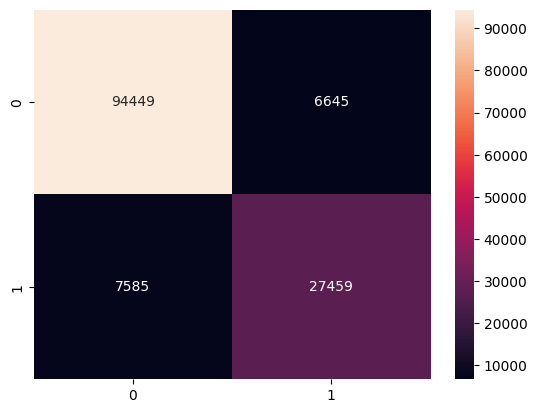

In [31]:
from sklearn.ensemble import RandomForestClassifier
#random forest classifier with n_estimators=100 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train[selected_features],y_train)

y_pred = clf_rf.predict(x_test[selected_features])

print("Classification Report:")
print(classification_report(y_test, y_pred))
                            
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt="d")

In [32]:
y_pred_prob = clf_rf.predict_proba(x_test[selected_features])[:, 1]
pred_df = pd.DataFrame(y_pred_prob, columns=['prediction'])
true_df = pd.DataFrame(y_test, columns=['target']).reset_index(drop=True)

amex_metric(true_df, pred_df)

0.7636394776094806

**XGBoost**

In [33]:
# XGBoost classifier
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(random_state=43)
clf_xgb.fit(x_train[selected_features], y_train)

y_pred = clf_xgb.predict(x_test[selected_features])

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93    101094
           1       0.81      0.80      0.80     35044

    accuracy                           0.90    136138
   macro avg       0.87      0.87      0.87    136138
weighted avg       0.90      0.90      0.90    136138



In [34]:
y_pred_prob = clf_xgb.predict_proba(x_test[selected_features])[:, 1]
pred_df = pd.DataFrame(y_pred_prob, columns=['prediction'])
true_df = pd.DataFrame(y_test, columns=['target']).reset_index(drop=True)

amex_metric(true_df, pred_df)

0.7779548067340316

**Logistic Regression**

In [35]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression classifier
clf_lr = LogisticRegression(random_state=43)
clf_lr.fit(x_train[selected_features], y_train)

y_pred = clf_lr.predict(x_test[selected_features])

print("Classification Report:")
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91    101094
           1       0.78      0.69      0.73     35044

    accuracy                           0.87    136138
   macro avg       0.84      0.81      0.82    136138
weighted avg       0.87      0.87      0.87    136138



In [36]:
y_pred_prob = clf_lr.predict_proba(x_test[selected_features])[:, 1]
pred_df = pd.DataFrame(y_pred_prob, columns=['prediction'])
true_df = pd.DataFrame(y_test, columns=['target']).reset_index(drop=True)

amex_metric(true_df, pred_df)

0.6867284661819631